## Installation

In [5]:
!apt install python3-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

!pip3 install pyvirtualdisplay numpy torch torchvision torchaudio gymnasium tqdm matplotlib jupyter

!pip install swig
!pip install gym[box2d]
!pip install box2d-py ipykernel ipywidgets widgetsnbextension

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [6]:
from collections import deque, namedtuple
import gc
import math
import pickle
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from matplotlib import pyplot as plt
import psutil
import gymnasium as gym

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

from IPython import display

## Implementation

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNModel(nn.Module):
  def __init__(self, state_dim, action_number):
    super(DQNModel, self).__init__()
    self.fc1 = nn.Linear(state_dim, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_number)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN:
  def __init__(
    self,
    state_dim,
    action_space,
    learning_rate=0.0001,
    epsilon = 1.0,
    epsilon_min=0.01,
    epsilon_decay=0.99,
    gamma=0.99,
    batch_size=128,
    buffer_size=2000,
  ):
    self.action_space = action_space
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.batch_size = batch_size
    self.learning_rate = learning_rate

    self.memory = deque([], maxlen=buffer_size)

    self.network = self.build_model(state_dim, 4)
    self.target_net = self.build_model(state_dim, 4)
    self.update_target_net()
    self.target_net.eval()

    self.optimizer = optim.AdamW(self.network.parameters(), lr=self.learning_rate, amsgrad = True)

    self.steps = 0

    self.loss_fn = nn.SmoothL1Loss()

  def build_model(self, state_dim, action_number):
    model = DQNModel(state_dim, action_number)
    model.to(device)
    return model

  def act(self, state):
    sample = random.random()

    epsilon_trsh = self.epsilon_min + (self.epsilon - self.epsilon_min) * math.exp(-1. * self.steps / self.epsilon_decay)

    self.steps += 1

    if sample < epsilon_trsh:
      action = torch.tensor([[self.action_space.sample()]], device = device, dtype=torch.long)
    else:
      with torch.no_grad():
        action = self.network(state).max(1)[1].view(1, 1)

    return action

  def preprocess_state(self, state):
    if isinstance(state, np.ndarray):
      state = tuple(state)
    state = torch.tensor(state, dtype = torch.float32, device = device).unsqueeze(0)
    return state

  def remember(self, state, action, reward, next_state):
    reward = torch.tensor([reward], device = device)
    self.memory.append(Transition(state, action, next_state, reward))

  def replay(self):
    if len(self.memory) < self.batch_size:
      return

    transitions = random.sample(self.memory,self.batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = self.network(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(self.batch_size, device=device)
    with torch.no_grad():
      next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

    expected_state_action = (next_state_values * self.gamma) + reward_batch

    loss = self.loss_fn(state_action_values, expected_state_action.unsqueeze(1))

    self.optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
    self.optimizer.step()

    self.update_target_net(0.001)

    self.epsilon = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon_min

  def update_target_net(self, tau = 1.0):
    for target_param, local_param in zip (self.target_net.parameters(), self.network.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)

  def load(self, name, ignore_epsilon=False):
    checkpoint = torch.load(name)
    self.network.load_state_dict(checkpoint['model_state_dict'])

    if not ignore_epsilon:
      self.epsilon = checkpoint['epsilon']

  def save(self, name):
    checkpoint = {
      'model_state_dict': self.network.state_dict(),
      'epsilon': self.epsilon
    }

    torch.save(checkpoint, name)

In [8]:
def plotLearning(x, scores, filename):
    plt.plot(scores)
    plt.title("Total Rewards")
    plt.savefig(filename)
    plt.show()

## Train the Agent

In [9]:
import datetime

Streaming output truncated to the last 5000 lines.
Episode: 1890
 Reward: 159.65 
 Avg Reward: 5.13 
 Last 100 Avg Reward: 9.79
2024-04-22 06:14:13.734068
Episode: 1891
 Reward: 171.81 
 Avg Reward: 7.06 
 Last 100 Avg Reward: 11.51
2024-04-22 06:14:16.646952
Episode: 1892
 Reward: -47.78 
 Avg Reward: 6.88 
 Last 100 Avg Reward: 11.03
2024-04-22 06:14:20.991279
Episode: 1893
 Reward: -15.41 
 Avg Reward: 7.19 
 Last 100 Avg Reward: 10.88
2024-04-22 06:14:24.505140
Episode: 1894
 Reward: -70.78 
 Avg Reward: 7.41 
 Last 100 Avg Reward: 10.17
2024-04-22 06:14:28.038803
Episode: 1895
 Reward: 75.38 
 Avg Reward: 8.51 
 Last 100 Avg Reward: 10.92
2024-04-22 06:14:31.941079
Episode: 1896
 Reward: -19.65 
 Avg Reward: 9.04 
 Last 100 Avg Reward: 10.73
2024-04-22 06:14:35.519371
Episode: 1897
 Reward: -30.88 
 Avg Reward: 9.88 
 Last 100 Avg Reward: 10.42
2024-04-22 06:14:38.939518
Episode: 1898
 Reward: -65.99 
 Avg Reward: 9.50 
 Last 100 Avg Reward: 9.76
2024-04-22 06:14:42.457488
Episode

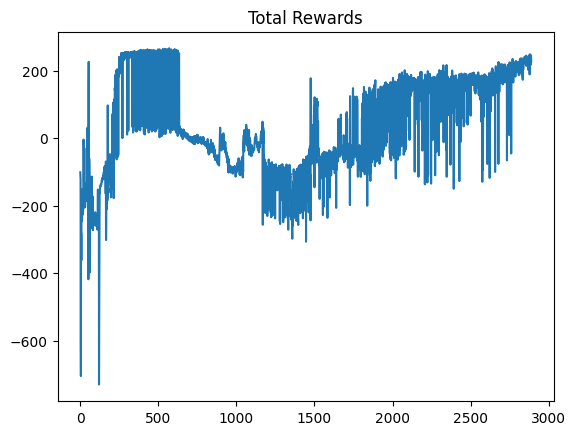

Solved in: 2890 episodes!


In [10]:
env = gym.make('LunarLander-v2')

agent = DQN(
  state_dim=8,
  action_space=env.action_space,
  gamma=0.99,
  epsilon=1.0,
  learning_rate=0.0001,
  buffer_size=2000,
  batch_size=128,
  epsilon_min=0.05,
  epsilon_decay=0.99
)
if os.path.isfile('./deepQNetwork.h5'):
  agent.load('./deepQNetwork.h5')

rewards = 0

total_rewards = []
last_100_rewards = np.zeros((100,), dtype=float)
eps_history = []
x = []
i = 1
episodes = 500
avg_reward = 0
try:
  while np.mean(last_100_rewards) < 200:
    print(f"Episode: {i}")
    state, info = env.reset(seed=4)
    state = agent.preprocess_state(state)
    done = False
    total_reward = 0

    if i % 100 == 0:
      last_100_rewards = np.zeros((100,), dtype=float)

    while not done:
      action = agent.act(state)
      next_state, reward, terminated, truncated, _ = env.step(action.item())
      done = terminated or truncated

      next_state = agent.preprocess_state(next_state)

      agent.remember(state, action, reward, next_state)

      if done:
        next_state = None

      state = next_state
      total_reward += reward

      agent.replay()

    total_rewards.append(total_reward)
    last_100_rewards[i % 100] = total_reward
    eps_history.append(agent.epsilon)

    avg_reward = np.mean(total_rewards[max(0, i-100): (i+1)])
    print(" Reward: %.2f" % total_reward, "\n Avg Reward: %.2f" % avg_reward, "\n Last 100 Avg Reward: %.2f" % np.mean(last_100_rewards))
    print(datetime.datetime.now())

    i += 1
    x.append(i)

  plotLearning(x, total_rewards, "lunar.png")

  print(f"Solved in: {i} episodes!")

finally:
  agent.save("deepQNetwork.h5")

## Training results

In [11]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

agent = DQN(
  state_dim=8,
  action_space=env.action_space
)

agent.load('./deepQNetwork.h5')

Game = namedtuple('Game', ['reward', 'frames'])
n_games = 10
games = []

for g in range(n_games):
  state, info = env.reset(seed=4)
  state = agent.preprocess_state(state)
  done = False
  total_reward = 0
  frames = []

  while not done:
    action = agent.act(state)
    next_state, reward, terminated, truncated, _ = env.step(action.item())
    done = terminated or truncated

    next_state = agent.preprocess_state(next_state)

    if done:
      next_state = None

    state = next_state
    total_reward += reward
    frames.append(env.render())

  print(f"Total reward: {total_reward}")
  games.append(Game(total_reward, frames))



env.close()

# Save video of the best game
import imageio
best_game = max(games, key=lambda g: g.reward)
print(f"Best game: {best_game.reward}")
imageio.mimsave('./lunar_lander.gif', best_game.frames)

worst_game = min(games, key=lambda g: g.reward)
print(f"Worst game: {worst_game.reward}")
imageio.mimsave('./lunar_lander_worst.gif', worst_game.frames)

Total reward: 241.63845384536756
Total reward: 239.53058068653087
Total reward: 128.29263614957952
Total reward: 235.40893193268926
Total reward: 245.10755057788845
Total reward: 231.37100586205509
Total reward: 234.14497697640638
Total reward: 225.7692184329905
Total reward: 228.37417478779338
Total reward: 240.33041603940475
Best game: 245.10755057788845
Worst game: 128.29263614957952


## Testing

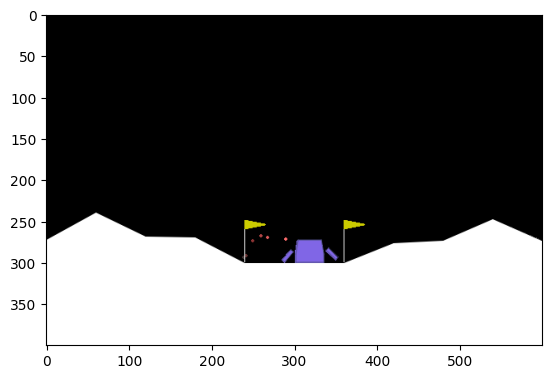

In [12]:
state, info = env.reset(seed=4)
state = agent.preprocess_state(state)

img = plt.imshow(env.render())

total_reward = 0

done = False
while not done:
    action = agent.act(state)
    next_state, reward, terminated, truncated, _ = env.step(action.item())
    done = terminated or truncated
    total_reward += reward
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
